# "American sign language classifier from scratch"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [classifier, scratch, vision]
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
from fastai.vision.all import *
import pandas as pd
from os import path
# torch.cuda.set_device(0)
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
# if path.exists('/storage'):
#     # Paperspace
#     train_df = pd.read_csv('/storage/data/asl/sign_mnist_train.csv')
#     test_df = pd.read_csv('/storage/data/asl/sign_mnist_test.csv')
# else:
#     # GCP
#     train_df = pd.read_csv('/home/jupyter/datasets/asl/sign_mnist_train.csv')
#     test_df = pd.read_csv('/home/jupyter/datasets/asl/sign_mnist_test.csv') 

# Randomly select 20% of training data as validation data
valid_df = train_df.sample(frac=0.2)
train_df = train_df.drop(valid_df.index)

train_df.shape, valid_df.shape, test_df.shape

((21964, 785), (5491, 785), (7172, 785))

In [3]:
train_df.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149


We have our training images in a dataframe where 1st value is the label and next 784 values are pixel intensities

In [4]:
# Select all the labels
def get_labels(df):
    return tensor(df.iloc[:, 0].values).to('cuda')

# Select all the pixel intensities and convert into a 1-D tensor of values between 0 to 1
def get_image_tensors(df):
    return torch.stack([tensor(image_array)/255. for image_array in df.iloc[:, 1:].values]).to('cuda')

def get_dataset(df):
    return zip(get_image_tensors(df), get_labels(df))

tensor(3, device='cuda:0')
tensor(6, device='cuda:0')


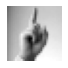

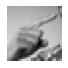

In [5]:
dataset = get_dataset(train_df)
labels = get_labels(train_df)

for image_tensor, label in list(dataset)[:2]:
    print(label)
    show_image(torch.reshape(image_tensor, (28, 28)), cmap='gray')

### Initialize weights

In [6]:
# Generate random weights between -1 and 1 and mark them to calculate gradient
def get_random_weights(rows, cols):
    return torch.randn(rows, cols).to('cuda').requires_grad_()

In [7]:
weights = get_random_weights(28*28, len(train_df.label.unique())+1)
bias = get_random_weights(1, len(train_df.label.unique())+1)
parameters = (weights, bias)

weights.shape, bias.shape

(torch.Size([784, 25]), torch.Size([1, 25]))

### Get Predictions 

In [7]:
image_tensors = get_image_tensors(train_df)
image_tensors.shape, weights.shape

(torch.Size([21964, 784]), torch.Size([784, 25]))

In [96]:
def get_predictions(image_tensors, weights, bias):
    return image_tensors@weights + bias

In [97]:
predictions = get_predictions(image_tensors, weights, bias)
predictions.shape

torch.Size([21964, 25])

Accuracy with random weights

In [10]:
def accuracy(df, parameters):
    weights, bias = parameters
    test_image_tensors, test_labels = get_image_tensors(valid_df), get_labels(valid_df)
    test_preds = get_predictions(test_image_tensors, weights, bias)
    pred_classes = torch.argmax(test_preds, dim=1)
    return (pred_classes == test_labels).float().mean() 

accuracy(valid_df, parameters)
# Random weights are ~5% accurate

tensor(0.0419, device='cuda:0')

### Calculate loss

As softmax function turns predictions into probabilities, each activation is bounded between (0, 1) hence our model considers 0.900 and 0.999 as the same but the second prediction is 100 times more confident hence we use log to amplify the domain to (-inf, inf)

In [40]:
def softmax(predictions, log=False):
    if log:
        return torch.log(torch.exp(predictions)/torch.exp(predictions).sum(dim=1, keepdim=True))
    return torch.exp(predictions)/torch.exp(predictions).sum(dim=1, keepdim=True)

# pytorch equivalent
activations_py = F.log_softmax(predictions, dim=1)

predictions[0][0], softmax(predictions)[0][0], softmax(predictions, log=True)[0][0], activations_py[0][0]

(tensor(10.7700, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(1.6697e-11, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(-24.8158, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(-24.8158, device='cuda:0', grad_fn=<SelectBackward>))

In [12]:
# gathers the corresponsing loss according to the label class
loss_of_each_image = activations.gather(1, labels.unsqueeze(-1))
max(loss_of_each_image), min(loss_of_each_image), loss_of_each_image.shape

(tensor([0.], device='cuda:0', grad_fn=<SelectBackward>),
 tensor([-inf], device='cuda:0', grad_fn=<SelectBackward>),
 torch.Size([21964, 1]))

There is a problem with applying log after softmax function, hence we use F.log_softmax() function provided by PyTorch

In [47]:
torch.log(F.softmax(tensor([62.0, -51.0]), dim=0)), F.log_softmax(tensor([62.0, -51.0]))a

<ipython-input-47-6adc8555dfc7>:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.log(F.softmax(tensor([62.0, -51.0]), dim=0)), F.log_softmax(tensor([62.0, -51.0]))


(tensor([0., -inf]), tensor([   0., -113.]))

In [52]:
loss = activations_py.gather(1, labels.unsqueeze(-1)).mean()

# pytorch equivalent 
loss_py = -F.nll_loss(activations_py, labels)

loss, loss_py

(tensor(-37.4764, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-37.4764, device='cuda:0', grad_fn=<NegBackward>))

In [63]:
# softmax + log + negative_loss_likelyhood = cross_entropy_loss: this can be used for classification problems
def cross_entropy_loss(predictions, labels): 
    activations = F.log_softmax(predictions, dim=1)
    loss = activations.gather(1, labels.unsqueeze(-1)).mean()
    return -loss

# pytorch equivalent
cross_entropy_loss_py = F.cross_entropy(predictions, labels)

cross_entropy_loss(predictions, labels), cross_entropy_loss_py

(tensor(37.4764, device='cuda:0', grad_fn=<NegBackward>),
 tensor(37.4764, device='cuda:0', grad_fn=<NllLossBackward>))

### Optimise weights

In [77]:
def train_epoch(dataloader, parameters, learning_rate, accuracy_func, valid_df, epoch_no):
    for image_tensors, labels in dataloader:
        weights, bias = parameters
        preds = get_predictions(image_tensors, weights, bias)
        
        loss = cross_entropy_loss(preds, labels)
        loss.backward()
        
        weights.data = weights.data - weights.grad*learning_rate
        bias.data -= bias.grad*learning_rate
        weights.grad.zero_()
        bias.grad.zero_()
        
    accuracy = accuracy_func(valid_df, (weights, bias))
    if epoch_no%5 == 0:
        print(f'epoch={epoch_no}; loss={loss}; accuracy={accuracy}')
    return weights, bias

In [80]:
def train(parameters, no_of_epochs, learning_rate, batch_size):
    for i in range(1, no_of_epochs+1):
        dl = DataLoader(get_dataset(train_df), batch_size=batch_size)
        weights, bias = train_epoch(dl, parameters, learning_rate, accuracy, valid_df, i)

In [81]:
train(parameters, no_of_epochs=50, learning_rate=1e-1, batch_size=1024)

epoch=5; loss=2.197233200073242; accuracy=0.3982881009578705
epoch=10; loss=2.051445722579956; accuracy=0.4283372759819031
epoch=15; loss=1.9267258644104004; accuracy=0.45346930623054504
epoch=20; loss=1.8183813095092773; accuracy=0.4744126498699188
epoch=25; loss=1.7231673002243042; accuracy=0.4929885268211365
epoch=30; loss=1.6387637853622437; accuracy=0.5155709385871887
epoch=35; loss=1.5634348392486572; accuracy=0.5310508012771606
epoch=40; loss=1.4958091974258423; accuracy=0.5439810752868652
epoch=45; loss=1.4347560405731201; accuracy=0.5543616414070129
epoch=50; loss=1.3793251514434814; accuracy=0.5654707551002502


In [83]:
train(parameters, no_of_epochs=50, learning_rate=1e-1, batch_size=2048)

epoch=5; loss=1.332802176475525; accuracy=0.5784010291099548
epoch=10; loss=1.3075464963912964; accuracy=0.5838645100593567
epoch=15; loss=1.2833633422851562; accuracy=0.5895100831985474
epoch=20; loss=1.260180950164795; accuracy=0.5953378081321716
epoch=25; loss=1.2379337549209595; accuracy=0.6015297770500183
epoch=30; loss=1.2165626287460327; accuracy=0.6057184338569641
epoch=35; loss=1.1960129737854004; accuracy=0.6106355786323547
epoch=40; loss=1.1762347221374512; accuracy=0.6184665560722351
epoch=45; loss=1.1571820974349976; accuracy=0.6224731206893921
epoch=50; loss=1.1388126611709595; accuracy=0.6277545094490051


If the learning seems to be slow we can increase the learning rate

In [84]:
train(parameters, no_of_epochs=50, learning_rate=3e-1, batch_size=2048)

epoch=5; loss=1.210028886795044; accuracy=0.6099070906639099
epoch=10; loss=1.389617681503296; accuracy=0.6073575019836426
epoch=15; loss=1.1752502918243408; accuracy=0.6150063872337341
epoch=20; loss=1.1438595056533813; accuracy=0.6357675790786743
epoch=25; loss=1.0695892572402954; accuracy=0.6654525399208069
epoch=30; loss=1.1350699663162231; accuracy=0.6567109823226929
epoch=35; loss=1.1996654272079468; accuracy=0.6572573184967041
epoch=40; loss=1.0542986392974854; accuracy=0.6873064637184143
epoch=45; loss=0.891987144947052; accuracy=0.7131670117378235
epoch=50; loss=0.9970915913581848; accuracy=0.689491868019104


In [86]:
train(parameters, no_of_epochs=50, learning_rate=4e-1, batch_size=1024)

epoch=5; loss=0.5388020277023315; accuracy=0.8198870420455933
epoch=10; loss=0.4986553192138672; accuracy=0.8228009343147278
epoch=15; loss=0.4944797158241272; accuracy=0.8269895911216736
epoch=20; loss=0.56035977602005; accuracy=0.7914769649505615
epoch=25; loss=0.524692714214325; accuracy=0.801311194896698
epoch=30; loss=0.40703633427619934; accuracy=0.8324530720710754
epoch=35; loss=0.44167599081993103; accuracy=0.819340705871582
epoch=40; loss=0.41297367215156555; accuracy=0.8442906141281128
epoch=45; loss=0.4123932123184204; accuracy=0.8535785675048828
epoch=50; loss=0.4013936519622803; accuracy=0.8594062924385071


In [87]:
train(parameters, no_of_epochs=50, learning_rate=4e-1, batch_size=1024)

epoch=5; loss=0.3804209530353546; accuracy=0.8603168725967407
epoch=10; loss=0.30301526188850403; accuracy=0.8767073154449463
epoch=15; loss=0.34746670722961426; accuracy=0.8706974983215332
epoch=20; loss=0.3037199378013611; accuracy=0.9082134366035461
epoch=25; loss=0.26886311173439026; accuracy=0.8921871781349182
epoch=30; loss=0.2956759035587311; accuracy=0.8892733454704285
epoch=35; loss=0.3053615987300873; accuracy=0.8728829026222229
epoch=40; loss=0.3092946410179138; accuracy=0.870879590511322
epoch=45; loss=0.2900395691394806; accuracy=0.880167543888092
epoch=50; loss=0.2876986861228943; accuracy=0.8807138800621033


In [88]:
train(parameters, no_of_epochs=50, learning_rate=1e-1, batch_size=4096)

epoch=5; loss=0.18215548992156982; accuracy=0.9544709324836731
epoch=10; loss=0.18170930445194244; accuracy=0.9551994204521179
epoch=15; loss=0.18126404285430908; accuracy=0.9555636048316956
epoch=20; loss=0.18082618713378906; accuracy=0.9555636048316956
epoch=25; loss=0.18039508163928986; accuracy=0.955927848815918
epoch=30; loss=0.17997007071971893; accuracy=0.9562920928001404
epoch=35; loss=0.17955094575881958; accuracy=0.9566563367843628
epoch=40; loss=0.17913728952407837; accuracy=0.957202672958374
epoch=45; loss=0.1787288933992386; accuracy=0.9575669169425964
epoch=50; loss=0.17832538485527039; accuracy=0.9575669169425964


We were able to achieve ~96% accuracy with just 1 layer of parameters